# 导入公共库

In [1]:
random_state=233

In [2]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

# 检查数据集状态

## 读取数据集

In [3]:
accidents=pd.read_csv('./data/uk_accident/Accidents0515.csv', index_col='Accident_Index')
vehicles=pd.read_csv('./data/uk_accident/Vehicles0515.csv', index_col='Accident_Index', error_bad_lines=False, warn_bad_lines=False)

In [4]:
uk_data=accidents.join(vehicles, how='outer')

## 数据预处理

### 去除无用特征

In [5]:
def drop_useless_feat(data, labels):
    # 删除无用列
    print('数据量: %d, 特征量: %d' % data.shape)
    return data.drop(
        labels=labels,
        axis=1
    )

In [6]:
labels_to_drop=[
        'Longitude',
        'Latitude',
        'Location_Easting_OSGR',
        'Location_Northing_OSGR',
        'Police_Force',
        'Number_of_Vehicles',
        'Number_of_Casualties',
        'Date',
        'Time',
        'Local_Authority_(District)',
        'Local_Authority_(Highway)',
        '1st_Road_Number',
        '2nd_Road_Number',
        'Did_Police_Officer_Attend_Scene_of_Accident',
        'LSOA_of_Accident_Location',
        'Vehicle_Reference',
        '1st_Point_of_Impact',
        'Sex_of_Driver',
        'Age_of_Driver',
        'Age_Band_of_Driver',
        'Was_Vehicle_Left_Hand_Drive?',
        'Journey_Purpose_of_Driver',
        'Driver_IMD_Decile',
        'Driver_Home_Area_Type',
    ]

In [7]:
# 删除无用列
uk_data=drop_useless_feat(uk_data, labels_to_drop)

数据量: 3144481, 特征量: 52


### 筛选特征

In [8]:
feat_to_use=[
    'Accident_Severity',
    # 'Longitude',
    # 'Latitude',
    'Engine_Capacity_(CC)',
    'Age_of_Vehicle',
    'Day_of_Week',
    'Vehicle_Type',
    'Vehicle_Manoeuvre',
    'Junction_Detail',
    '1st_Road_Class',
    'Junction_Location',
]

In [9]:
uk_data=uk_data[feat_to_use]

### 清除空数据

In [10]:
def drop_empty(data):
    for col in data.columns:
        data=data[data[col]!=-1]
    return data.dropna()

In [11]:
uk_data=drop_empty(uk_data)

## 展示数据集

In [12]:
def show_severity_distribution(data, labels=['Slight', 'Serious', 'Fatal'], log=True):
    if not isinstance(data, pd.DataFrame):
        data=pd.DataFrame(data)
    val_cnt=pd.DataFrame(data.value_counts())
    val_cnt.sort_index(inplace=True, ascending=False)
    print(val_cnt)
    ratio=val_cnt[0].values
    print(f'ratio = {(ratio/np.min(ratio)).tolist()}')
    sns.barplot(
        x=labels, 
        y=val_cnt[0].values,
        log=log,
    )

                         0
Accident_Severity         
3                  1820643
2                   256313
1                    28524
ratio = [63.82846024400505, 8.985871546767635, 1.0]


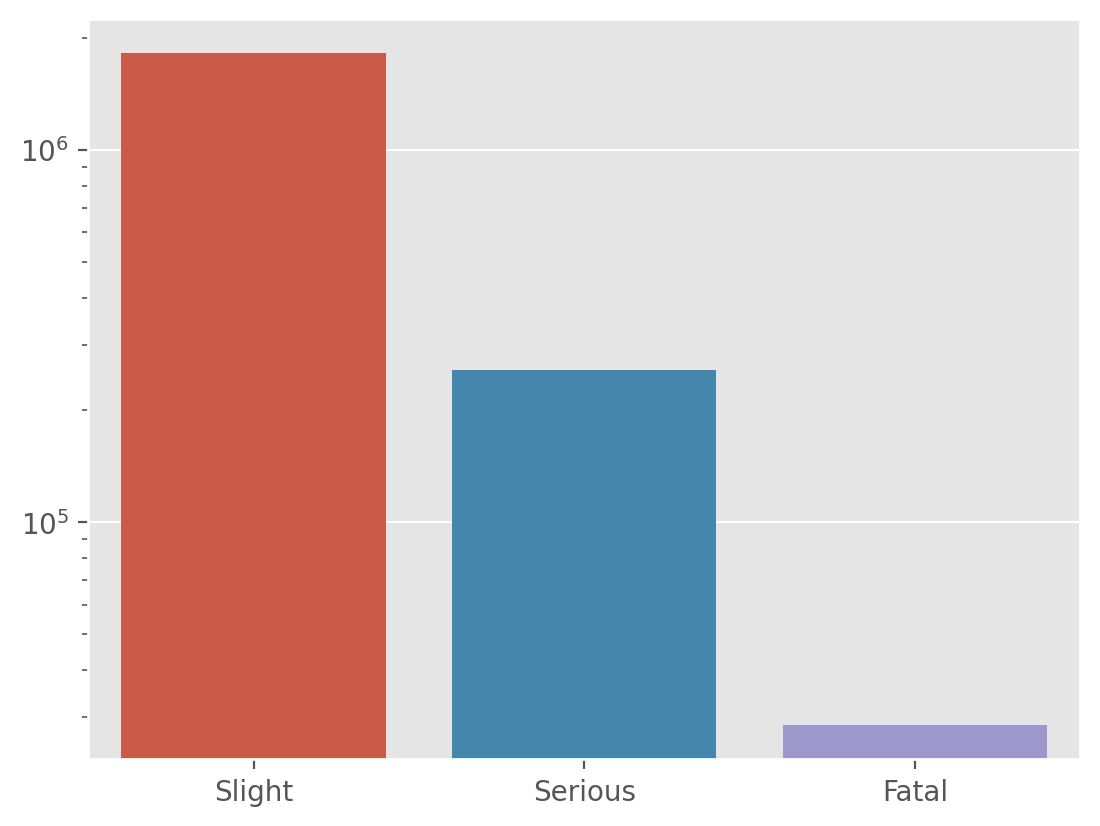

In [13]:
show_severity_distribution(uk_data.Accident_Severity)

三种程度的事故数量从轻到重逐级下降一个数量级

# 原始数据切分

In [14]:
def split_X_y(data, ylabels):
    y=data[ylabels].copy()
    X=data.drop(labels=ylabels, axis=1)
    return X, y

In [15]:
X, y = split_X_y(uk_data, 'Accident_Severity')

In [16]:
# y[y==3] = 0
# y[y==2] = 1
# # y[y==1] = 1

In [17]:
y.value_counts()

0    1820643
1     284837
Name: Accident_Severity, dtype: int64

In [18]:
print('数据量: %d, 特征量: %d' % X.shape)

数据量: 2105480, 特征量: 8


                         0
Accident_Severity         
1                   284837
0                  1820643
ratio = [1.0, 6.391876757584162]


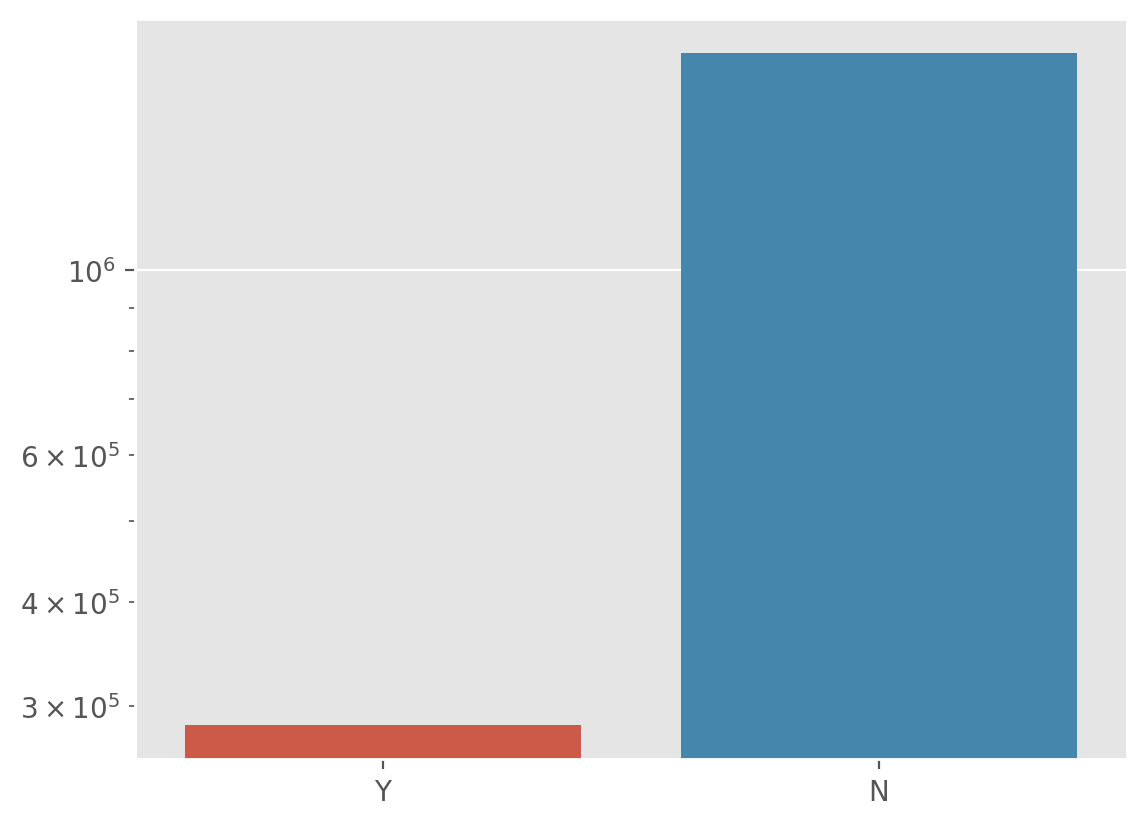

In [19]:
show_severity_distribution(y)

## 标准化

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

# 数据不平衡处理

In [22]:
def resample(sampler, data_X, data_y, random_state=0):
    t0=time()
    X_res, y_res = sampler.fit_resample(data_X, data_y)
    dt=time()-t0
    print(f'{sampler.__class__.__name__} 采样耗时: {dt/60.0 if dt > 60.0 else dt:.2f}{"s" if dt < 60.0 else "m"}')
    return X_res, y_res

## 过采样

### Random Over Sampling

In [84]:
from imblearn.over_sampling import RandomOverSampler

In [85]:
os_random_X, os_random_y=resample(
    RandomOverSampler(random_state=0),
    data_X=X,
    data_y=y,
)

RandomOverSampler 采样耗时: 0.83s


In [86]:
show_severity_distribution(os_random_y)

   Accident_Severity
1            1820643
0            1820643


KeyError: 'Slight'

### SMOTE
> SMOTE（Synthetic Minority Oversampling Technique）
> 
> 即合成少数类过采样技术，它是基于随机过采样算法的一种改进方案，，SMOTE算法的基本思想是对少数类样本进行分析并根据少数类样本人工合成新样本添加到数据集中。

In [27]:
from imblearn.over_sampling import SMOTE

In [28]:
os_smote_X, os_smote_y=resample(
    SMOTE(random_state=0),
    data_X=X,
    data_y=y,
)

SMOTE 采样耗时: 5.65s


   Accident_Severity
3             830713
2             830713
1             830713


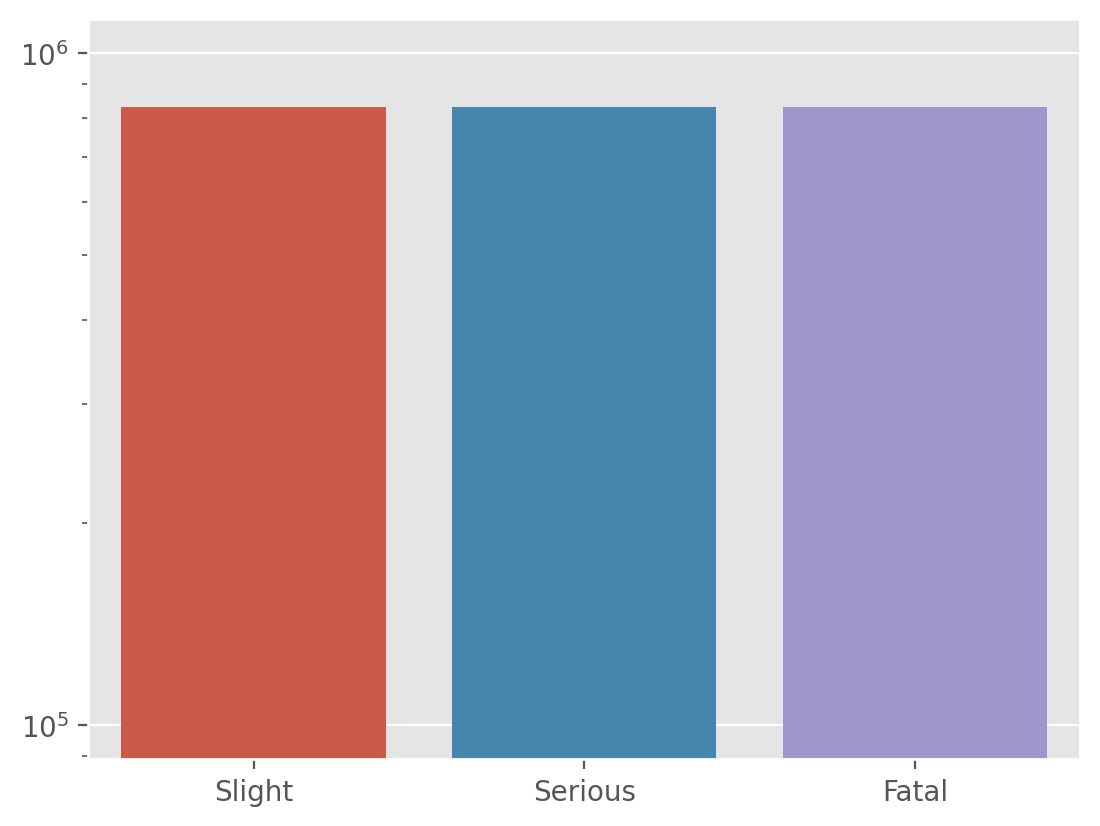

In [29]:
show_severity_distribution(os_smote_y)

### BorderlineSMOTE

In [30]:
from imblearn.over_sampling import BorderlineSMOTE

In [31]:
os_smote_borderline_X, os_smote_borderline_y=resample(
    BorderlineSMOTE(random_state=0, n_jobs=-1),   
    data_X=X,
    data_y=y,
)

BorderlineSMOTE 采样耗时: 29.45s


   Accident_Severity
3             830713
2             830713
1             830713


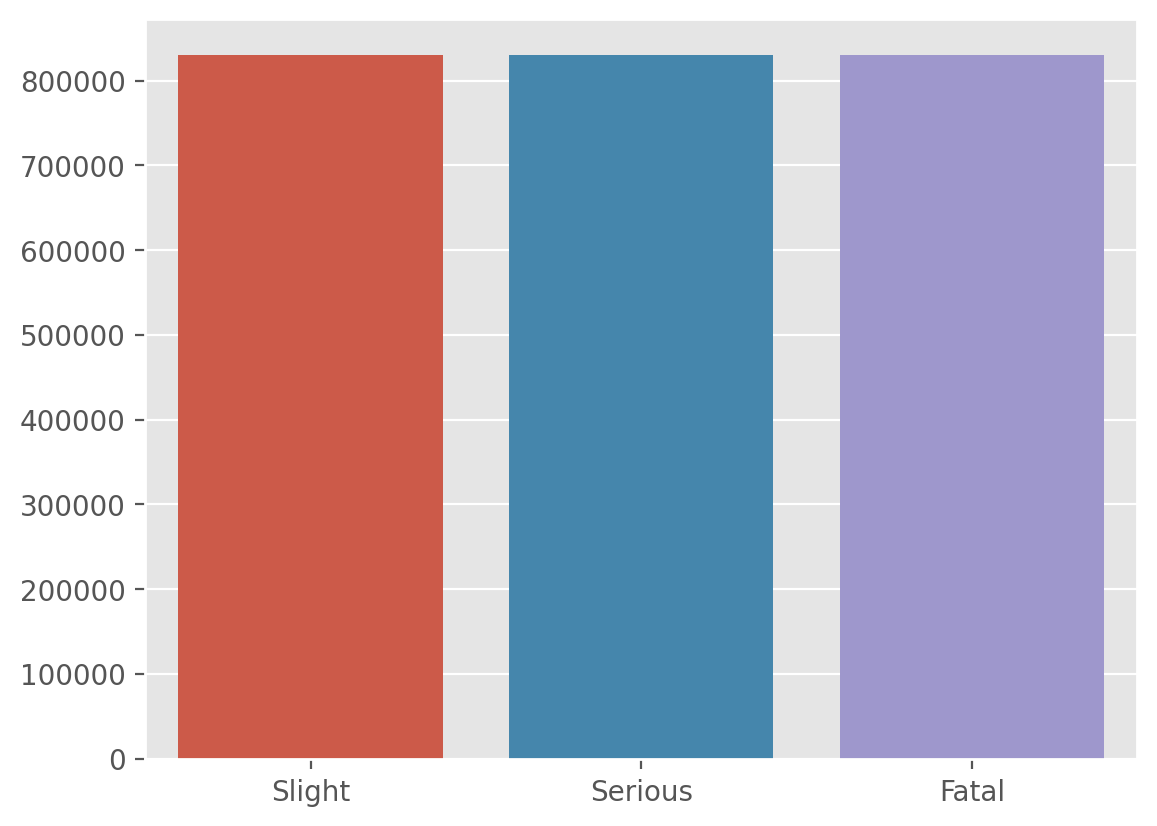

In [32]:
show_severity_distribution(os_smote_borderline_y, log=False)

### KMeansSMOTE

In [33]:
from imblearn.over_sampling import KMeansSMOTE

In [34]:
os_smote_kmeans_X, os_smote_kmeans_y=resample(
    KMeansSMOTE(random_state=0, cluster_balance_threshold=0.01),
    data_X=X,
    data_y=y,
)

KMeansSMOTE 采样耗时: 25.66s


   Accident_Severity
3             830713
2             830718
1             830713


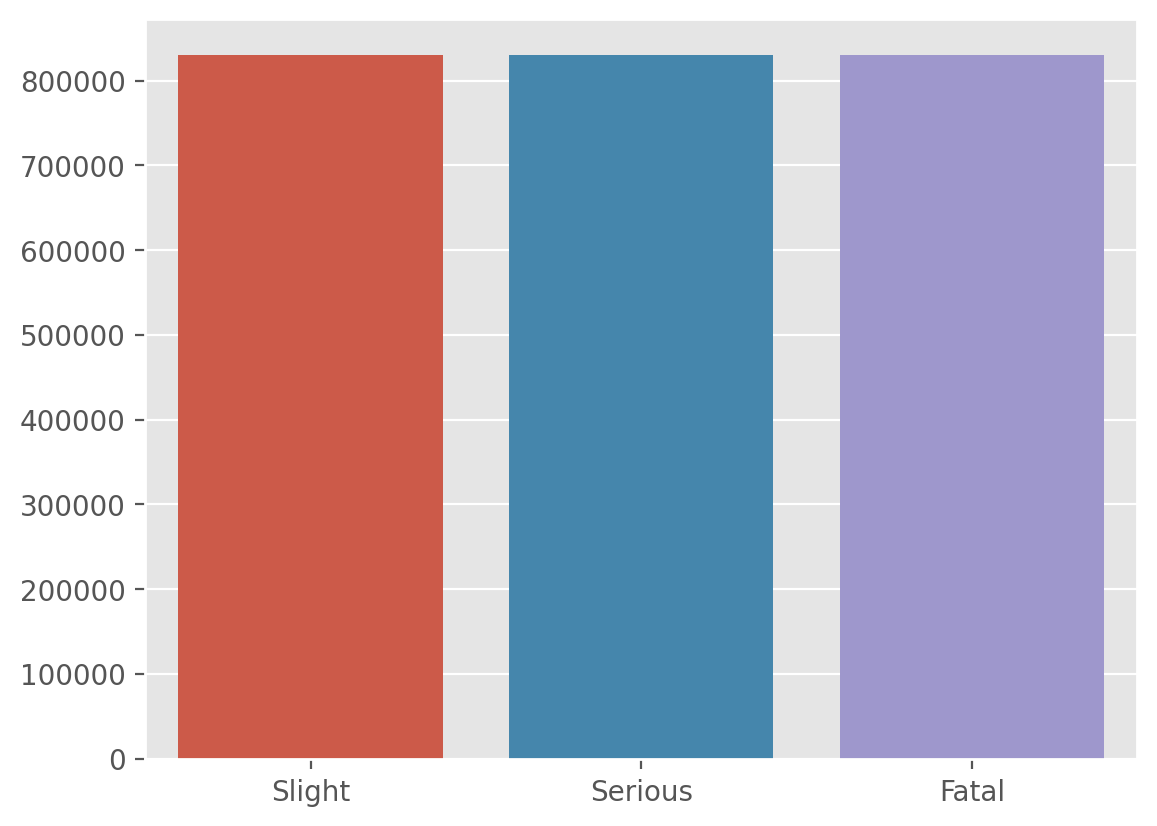

In [35]:
show_severity_distribution(os_smote_kmeans_y, log=False)

### ADASYN
> ADASYN 过采样方法专注于kNN难例

In [36]:
from imblearn.over_sampling import ADASYN

In [37]:
os_adasyn_X, os_adasyn_y=resample(
    ADASYN(random_state=0),   
    data_X=X,
    data_y=y,
)

ADASYN 采样耗时: 27.83s


   Accident_Severity
3             830713
2             834994
1             830156


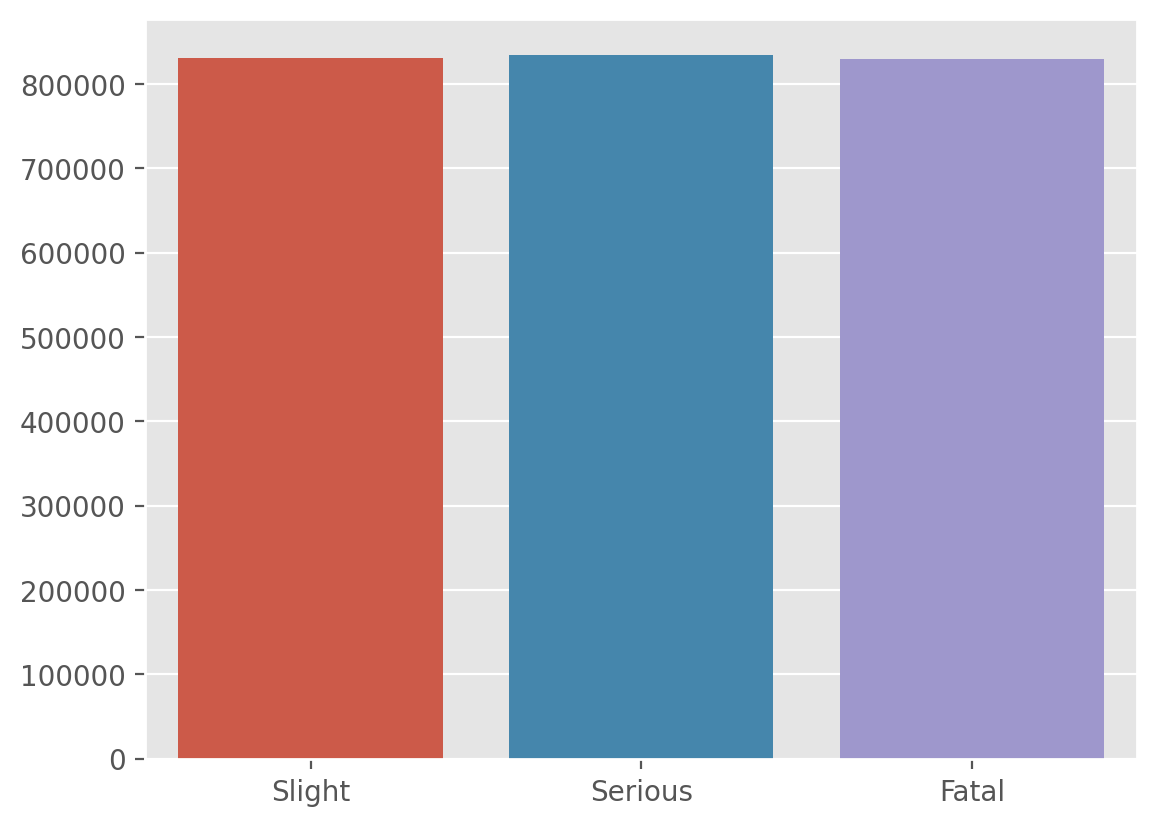

In [38]:
show_severity_distribution(os_adasyn_y, log=False)

   Accident_Severity
3             830713
2             830718
1             830713


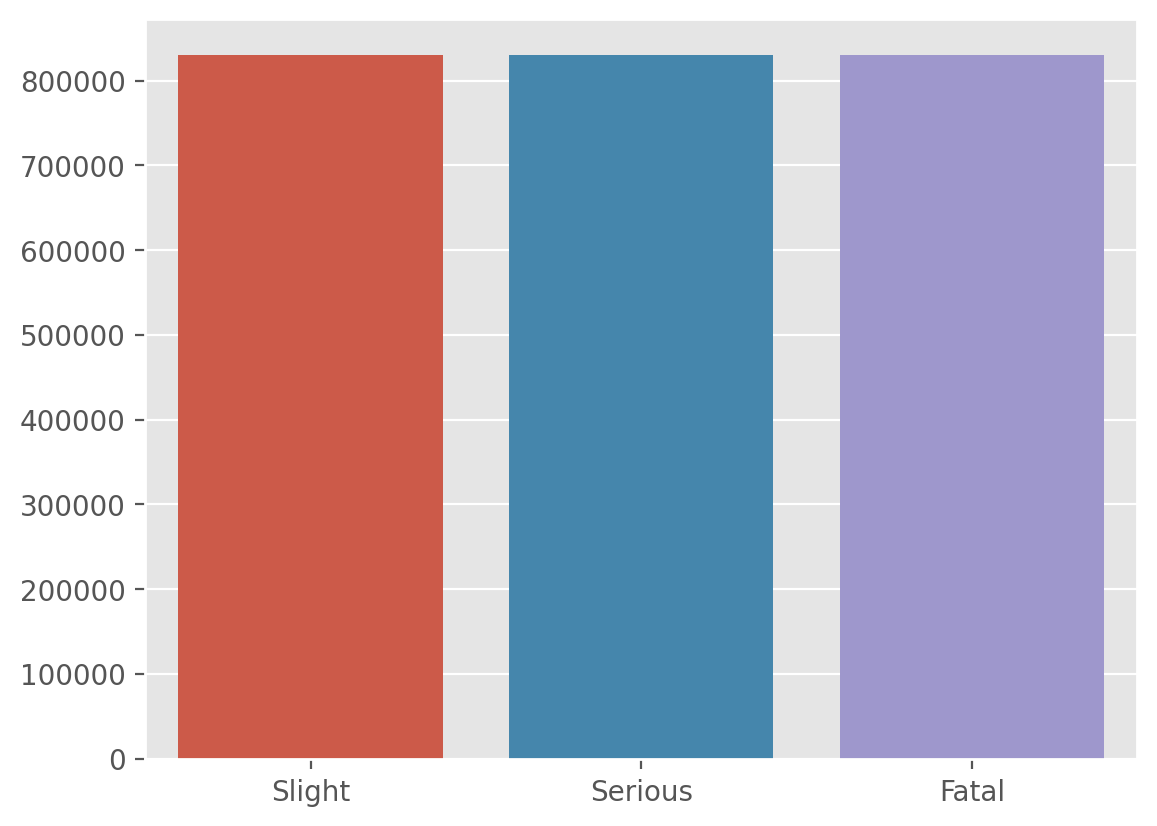

In [39]:
show_severity_distribution(os_smote_kmeans_y, log=False)

## 欠采样

### Random Under Sampling

In [37]:
from imblearn.under_sampling import RandomUnderSampler

In [38]:
us_random_X, us_random_y=resample(
    RandomUnderSampler(random_state=0),
    data_X=X,
    data_y=y,
)

RandomUnderSampler 采样耗时: 0.63s


   Accident_Severity
1             284837
0             284837
ratio = [1.0, 1.0]


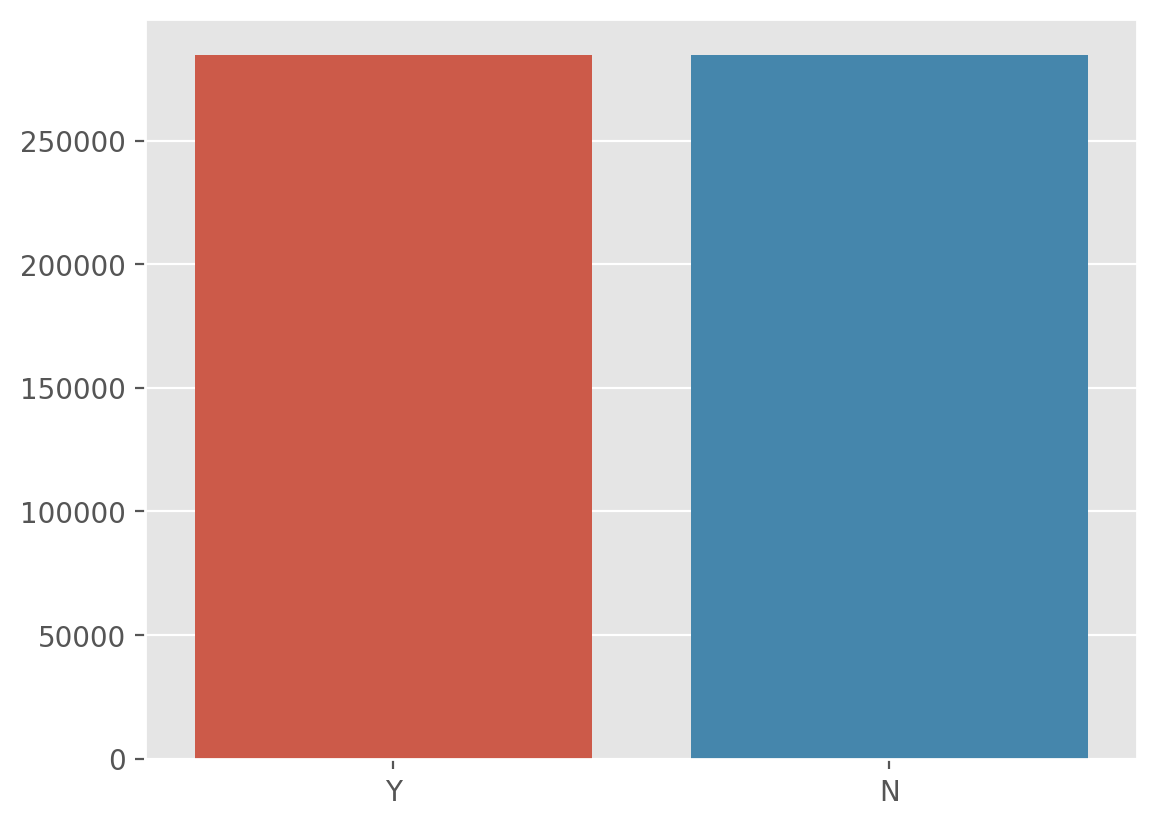

In [39]:
show_severity_distribution(us_random_y, labels=['Y', 'N'], log=False)

### Edited Nearest Neighbours

In [40]:
from imblearn.under_sampling import EditedNearestNeighbours

In [41]:
us_enn_X, us_enn_y=resample(
    EditedNearestNeighbours(sampling_strategy='majority', n_jobs=-1),
    data_X=X,
    data_y=y
)

EditedNearestNeighbours 采样耗时: 1.36s


   Accident_Severity
1             284837
0            1268427
ratio = [1.0, 4.453167952197221]


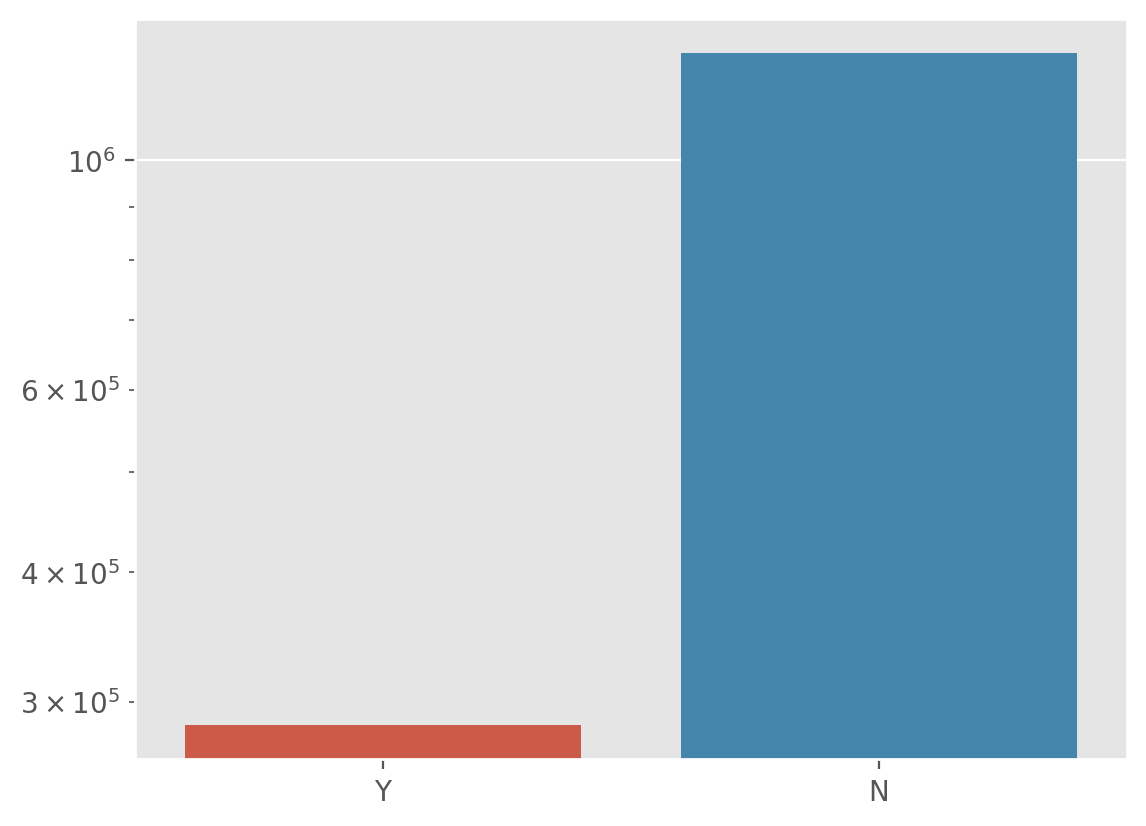

In [42]:
show_severity_distribution(us_enn_y)

### TomeLinks

In [30]:
from imblearn.under_sampling import TomekLinks

In [31]:
us_tkl_X, us_tkl_y=resample(
    TomekLinks(n_jobs=-1, sampling_strategy='majority'),
    X,
    y
)

TomekLinks 采样耗时: 80.21s


   Accident_Severity
1             284837
0            1767579


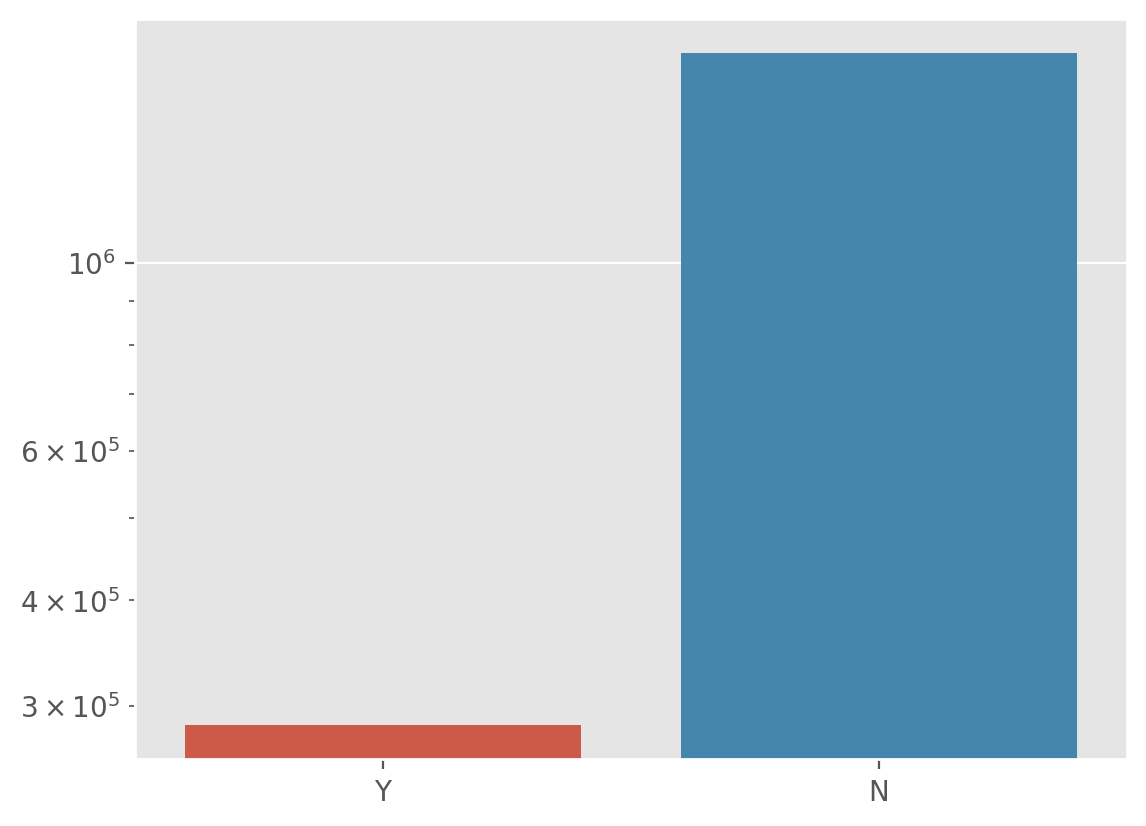

In [32]:
show_severity_distribution(us_tkl_y, labels=['Y', 'N'])

### RepeatedEditedNearestNeighbours

In [23]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

In [24]:
renn=RepeatedEditedNearestNeighbours(sampling_strategy='majority', n_jobs=-1)
us_renn_X, us_renn_y=resample(
    renn,
    data_X=X,
    data_y=y
)


KeyboardInterrupt



In [ ]:
print(f'enn 运行次数 = {renn.n_iter_}')

In [56]:
# 保存数据
np.savez_compressed(file='./data/uk_accident/UnderSampledData-0515-RepeatedENN', us_renn_X=us_renn_X, us_renn_y=us_renn_y)

In [24]:
!ls -alh data/uk_accident/

total 656M
drwxr-xr-x 4 root root 4.0K Jan 30 12:45 .
drwxr-xr-x 5 root root   76 Jan 29 09:33 ..
-rw-r--r-- 1 root root 234M Sep 20  2019 Accidents0515.csv
-rw-r--r-- 1 root root 104M Sep 20  2019 Casualties0515.csv
drwxr-xr-x 2 root root 4.0K Jan 21 19:38 contextCSVs
-rw-r--r-- 1 root root 112M Jan 21 19:38 dft-accident-data.zip
drwxr-xr-x 2 root root    6 Jan 30 12:45 .ipynb_checkpoints
-rw-r--r-- 1 root root  985 Sep 20  2019 tidydata.sh
-rw-r--r-- 1 root root  11M Jan 30 12:53 UnderSampledData-0515-RepeatedENN.npz
-rw-r--r-- 1 root root 198M Sep 20  2019 Vehicles0515.csv


In [25]:
# 读取数据
us_renn=np.load(file='./data/uk_accident/UnderSampledData-0515-RepeatedENN.npz')
us_renn_X, us_renn_y=us_renn['us_renn_X'], us_renn['us_renn_y']

         0
0         
1   284837
0  1090007
ratio = [1.0, 3.8267746114444403]


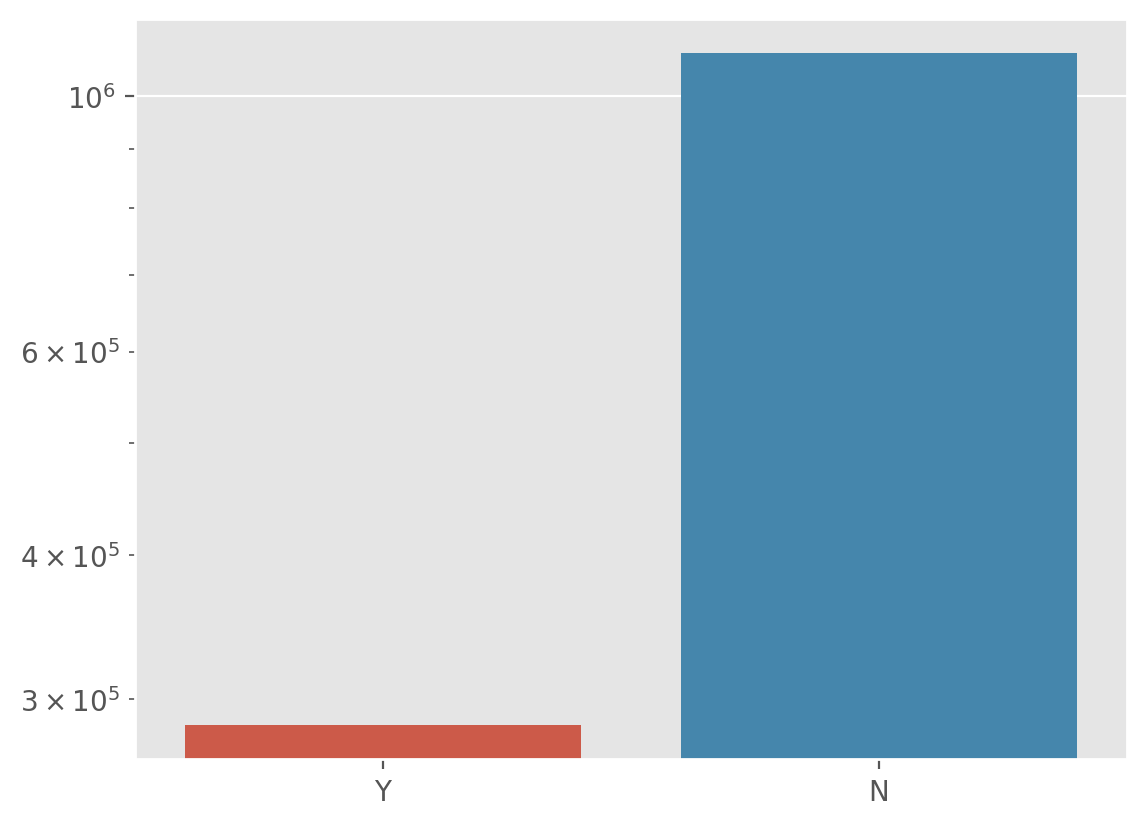

In [26]:
show_severity_distribution(us_renn_y)

### OneSidedSelection

In [86]:
from imblearn.under_sampling import OneSidedSelection

In [87]:
oss=OneSidedSelection(sampling_strategy='majority', random_state=random_state, n_jobs=-1)
us_oss_X, us_oss_y=resample(
    oss,
    data_X=X,
    data_y=y
)

OneSidedSelection 采样耗时: 4.99m


                         0
Accident_Severity         
1                   284837
0                  1767774
ratio = [1.0, 6.206265337719468]


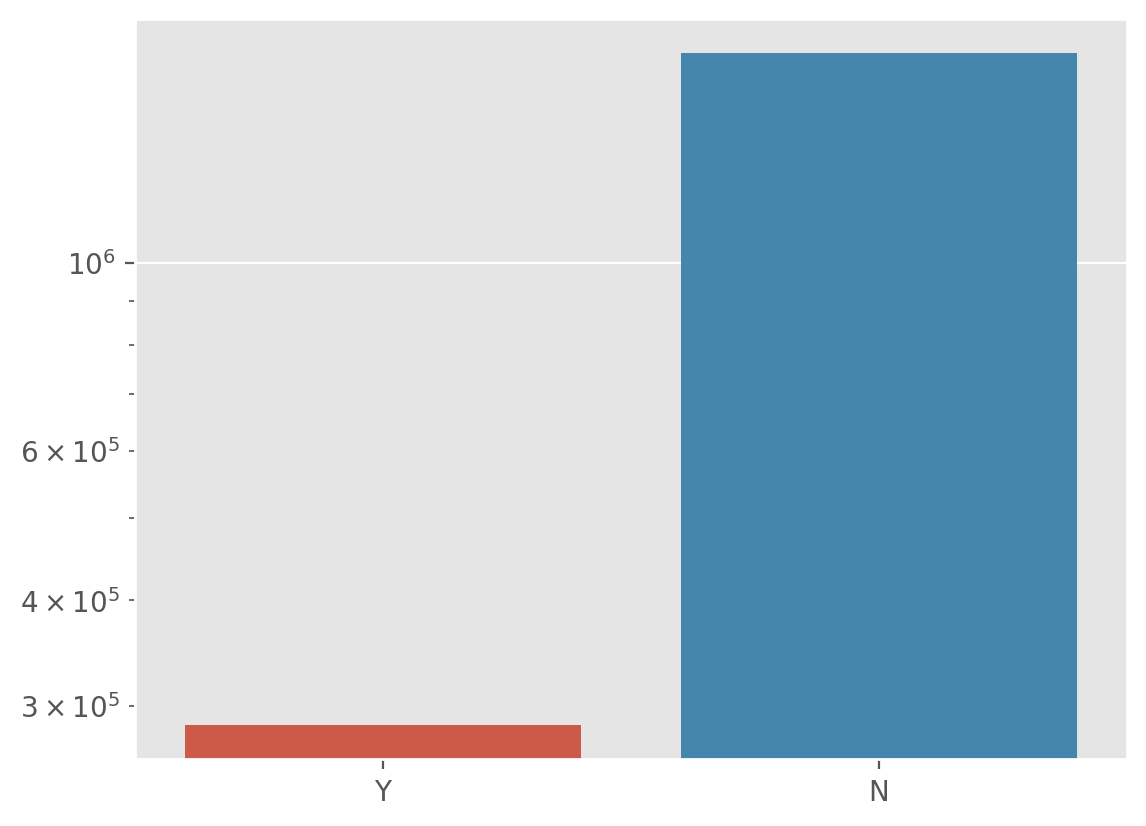

In [88]:
show_severity_distribution(us_oss_y, labels=['Y', 'N'])

### NeighbourhoodCleaningRule

In [81]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

In [84]:
ncr=NeighbourhoodCleaningRule(sampling_strategy='majority', n_jobs=-1, threshold_cleaning=0.3)
us_ncr_X, us_ncr_y=resample(
    ncr,
    data_X=X,
    data_y=y
)

NeighbourhoodCleaningRule 采样耗时: 2.01m


                         0
Accident_Severity         
1                   284837
0                  1325819
ratio = [1.0, 4.6546586293213315]


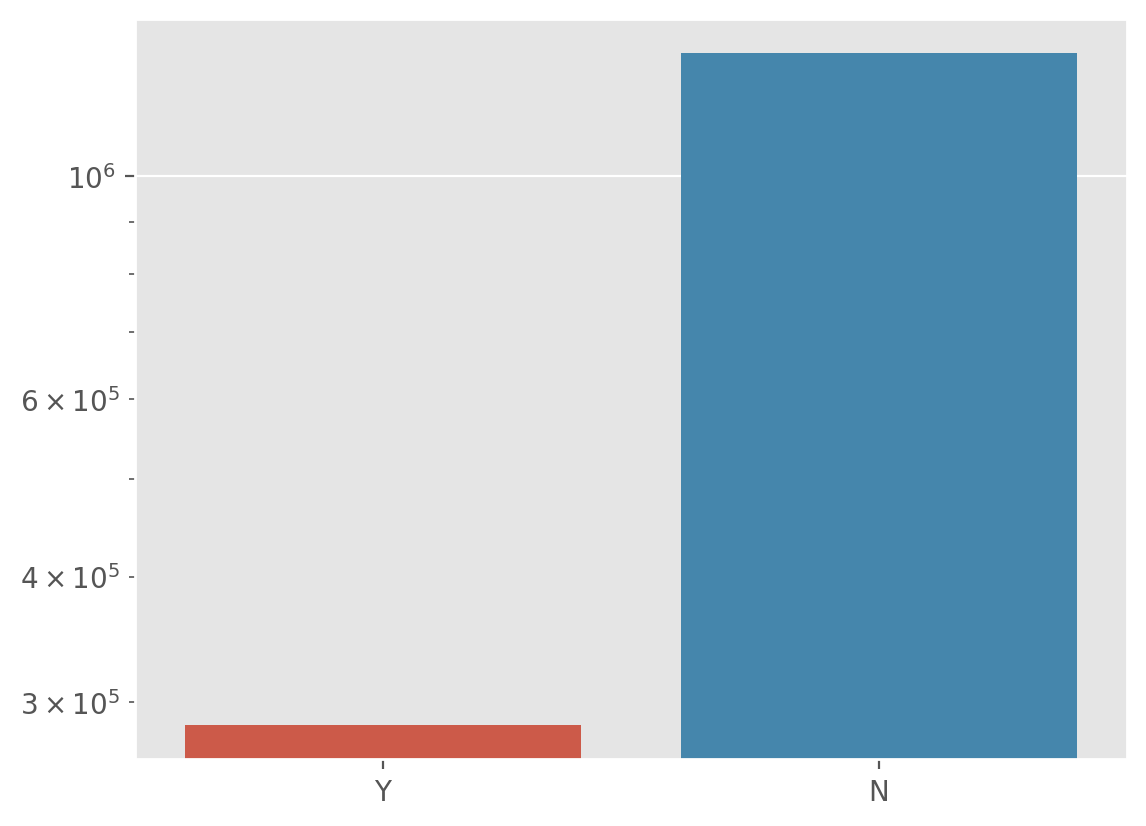

In [85]:
show_severity_distribution(us_ncr_y, labels=['Y', 'N'])

## 混合采样

### SMOTEENN

In [52]:
from imblearn.combine import SMOTEENN

In [53]:
combine_smote_enn_X, combine_smote_enn_y=resample(
    SMOTEENN(random_state=0, n_jobs=-1),
    X,
    y
)

KeyboardInterrupt: 

In [ ]:
show_severity_distribution(combine_smote_enn_y, log=False)

### SMOTETomek

In [ ]:
from imblearn.combine import SMOTETomek

In [ ]:
combine_smote_tomek_X, combine_smote_tomek_y=resample(
    SMOTETomek(random_state=0, n_jobs=-1),
    X,
    y
)

In [ ]:
show_severity_distribution(combine_smote_tomek_y, log=False)

# 机器学习

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
"""
拟合模型并评估模型
"""
def fit_predict(estimator, data_x, data_y, valid_X=None, valid_y=None, test_size=0.2, random_state=None, need_confusion_matrix:bool=False, confusion_normalize:str='true'):
    X_train, X_test, y_train, y_test = train_test_split(
        data_x,
        data_y,
        test_size=test_size,
        random_state=0,
    )
    # 执行训练
    t0=time()
    estimator.fit(X_train, y_train)
    print(f'{estimator.__class__.__name__} 训练耗时: {time()-t0:.2f}s')
    # 执行预测
    train_acc=accuracy_score(y_train, estimator.predict(X_train))
    y_pred=estimator.predict(X_test)
    test_acc=accuracy_score(y_test, y_pred)
    print(f'{estimator.__class__.__name__} [train_acc]={train_acc*100:.2f}')
    print(f'{estimator.__class__.__name__} [ test_acc]={test_acc*100:.2f}')
    valid_acc=None
    if valid_X is not None and valid_y is not None:
        valid_acc=accuracy_score(valid_y, estimator.predict(valid_X))
        print(f'{estimator.__class__.__name__} [valid_acc]={valid_acc*100:.2f}')
    return train_acc, \
            test_acc, \
            valid_acc, \
            confusion_matrix(y_test, y_pred, normalize=confusion_normalize) if need_confusion_matrix else None

In [28]:
from collections import defaultdict
"""
学习函数
"""
def learn(datasets, get_estimators, keep_all_models:bool=False, validset:tuple=None, show_confusion_matrix:bool=False):
    best_models=dict()
    n_datasets=len(datasets)
    n_estimators=len(get_estimators())
    if show_confusion_matrix:
        fig, axes=plt.subplots(n_datasets, n_estimators)
        if n_datasets == 1:
            axes=[axes]
            if n_estimators == 1:
                axes=[axes]

    if keep_all_models:
        all_models=defaultdict(dict)
            
    for sampling_method_name, ax_row in zip(datasets.keys(), axes):
        print("="*10, f'sampling method -> [ {sampling_method_name} ]', "="*10)
        if not keep_all_models:
            top_acc=0.0
            top_model=None
        is_first_estimator=True
        for model, ax in zip(get_estimators(), ax_row):
            dx, dy = datasets[sampling_method_name]
            if validset is not None:
                vx, vy = validset
            else:
                vx, vy = None, None
            
            # 训练模型，并获取测试精度
            _, test_acc, valid_acc, confusion = fit_predict(model, dx, dy, vx, vy, random_state=random_state, need_confusion_matrix=show_confusion_matrix)
            
            if keep_all_models:
                # 保存所有模型
                all_models[sampling_method_name][f'{model.__class__.__name__}']={'model':model, 'acc': test_acc}            
            else:
                # 保存最优模型
                if valid_acc is not None and valid_acc > top_acc:
                    top_acc=valid_acc
                    top_model=model
                elif test_acc > top_acc:
                    top_acc=test_acc
                    top_model=model
            
                
            # 绘制混淆矩阵
            if show_confusion_matrix:
                # sns.heatmap(data=confusion, ax=ax, square=True, annot=True, fmt='.2g', linewidths=0.5)
                sns.heatmap(data=confusion, ax=ax, annot=True, fmt='.2g', linewidths=0.5)
                ax.set_title(f'{model.__class__.__name__}')
                if is_first_estimator:
                    ax.set_ylabel(f'{sampling_method_name}')
                    is_first_estimator=False
        
        if not keep_all_models:        
            best_models[sampling_method_name]={'model':top_model, 'acc':top_acc}
        
    plt.show()
    
    return all_models if keep_all_models else best_models

## 上采样数据集

In [ ]:
over_sampling_dataset={
    'RandomOverSampling': (os_random_X, os_random_y),
    'SMOTE': (os_smote_X, os_smote_y),
    'BorderlineSMOTE': (os_smote_borderline_X, os_smote_borderline_y),
    'KMeansSMOTE': (os_smote_kmeans_X, os_smote_kmeans_y),
    'ADASYN': (os_adasyn_X, os_adasyn_y),
}

### 创建模型

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

def os_models():
    return [
        # LogisticRegression(random_state=random_state),
        DecisionTreeClassifier(random_state=random_state),
        # MLPClassifier(
        #     random_state=random_state,
        #     solver='sgd',
        #     learning_rate_init=0.3,
        #     learning_rate='adaptive',
        #     batch_size=500,
        #     verbose=True,
        # ),
        ExtraTreesClassifier(random_state=random_state),
    ]

### 开始训练

In [ ]:
os_best_models=learn(over_sampling_dataset, os_models, (X_valid, y_valid))

## 下采样数据集

In [29]:
under_sampling_dataset={
    # 'RandomUnderSampling': (us_random_X, us_random_y),
    # 'EditedNearestNeighbours': (us_enn_X, us_enn_y),
    # 'TomeLinks': (us_tkl_X, us_tkl_y),
    'RepeatedEditedNearestNeighbours': (us_renn_X, us_renn_y),
    # 'OneSidedSelection': (us_oss_X, us_oss_y),
    # 'NeighbourhoodCleaningRule': (us_ncr_X, us_ncr_y),
}

In [71]:
from sklearn.model_selection import GridSearchCV

gs=GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        # 'min_samples_split': [0.05 * i for i in range(1, 5)],
        # 'min_samples_leaf': [0.05 * i for i in range(1, 5)],
        # 'class_weight': [
        #     {'Y': 3.0, 'N': 1.0},
        #     'balanced',
        # ],
    },
    scoring='f1',
    n_jobs=-1,
    verbose=6,
)

In [72]:
t0=time()
hyper=gs.fit(us_renn_X, us_renn_y)
print(f'search cost {time()-t0:.2f} s')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
search cost 22.59 s


In [73]:
accuracy_score(us_renn_y, hyper.best_estimator_.predict(us_renn_X))

0.9766184381646209

In [74]:
hyper.best_params_

{'criterion': 'gini', 'splitter': 'random'}

### 创建模型

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

def us_models():
    return [
        # AdaBoostClassifier(n_estimators=100),
        DecisionTreeClassifier(random_state=random_state),
        # MLPClassifier(
        #     random_state=random_state,
        #     solver='sgd',
        #     learning_rate_init=0.3,
        #     learning_rate='adaptive',
        #     batch_size=200,
        #     hidden_layer_sizes=(18, 6),
        # ),
        ExtraTreesClassifier(random_state=random_state),
    ]

### 开始训练

In [54]:
!pip install skops

/bin/sh: pip: command not found


========== sampling method -> [ RepeatedEditedNearestNeighbours ] ==========
DecisionTreeClassifier 训练耗时: 8.69s
DecisionTreeClassifier [train_acc]=97.67
DecisionTreeClassifier [ test_acc]=84.46
ExtraTreesClassifier 训练耗时: 102.44s
ExtraTreesClassifier [train_acc]=97.67
ExtraTreesClassifier [ test_acc]=89.88


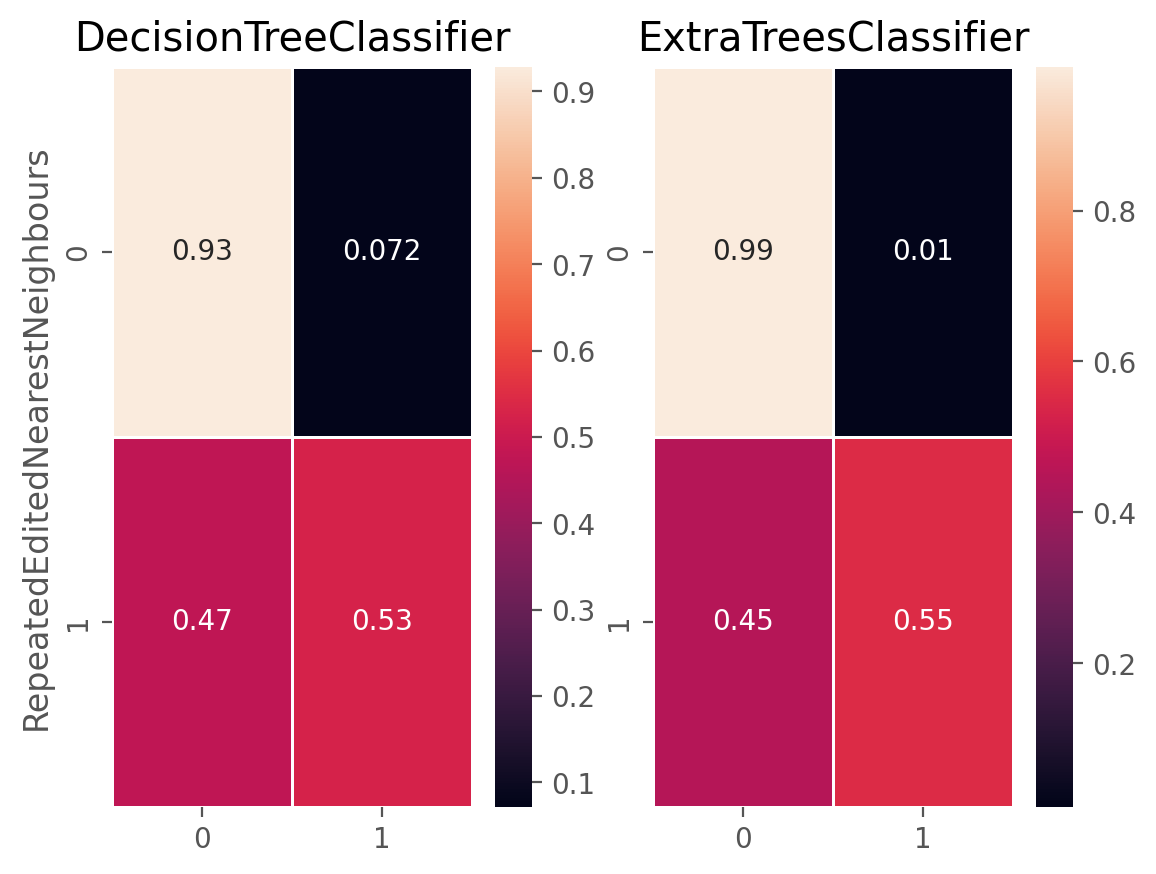

In [31]:
us_best_models=learn(under_sampling_dataset, us_models, show_confusion_matrix=True, keep_all_models=True)

## 混合采样数据集

In [ ]:
combine_sampling_dataset={
    'SMOTE_ENN': (combine_smote_enn_X, combine_smote_enn_y),
    'SMOTE_Tomek': (combine_smote_tomek_X, combine_smote_tomek_y),
}

### 创建模型

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

cs_models=[
    # LogisticRegression(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    # MLPClassifier(
    #     random_state=random_state,
    #     solver='sgd',
    #     learning_rate_init=0.3,
    #     learning_rate='adaptive',
    #     batch_size=500,
    #     verbose=True,
    # ),
    ExtraTreesClassifier(random_state=random_state),
]

### 开始训练

In [ ]:
cs_best_models=learn(combine_sampling_dataset, cs_models, (X_valid, y_valid))

## 集成学习

In [30]:
ensemble_dataset={
    # 'RandomUnderSampling': (us_random_X, us_random_y),
    # 'EditedNearestNeighbours': (us_enn_X, us_enn_y),
    # 'TomeLinks': (us_tkl_X, us_tkl_y),
    'RepeatedEditedNearestNeighbours': (us_renn_X, us_renn_y),
    # 'OneSidedSelection': (us_oss_X, us_oss_y),
    # 'NeighbourhoodCleaningRule': (us_ncr_X, us_ncr_y),
}

### 创建模型

In [50]:
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

def ensemble_models():
    return [
        # EasyEnsembleClassifier(n_estimators=20, random_state=random_state, n_jobs=-1),
        # RUSBoostClassifier(random_state=random_state),
        BalancedRandomForestClassifier(n_jobs=-1),
        # EasyEnsembleClassifier(
        #     estimator=DecisionTreeClassifier(
        #         criterion='gini',
        #         splitter='random',
        #         # random_state=random_state,
        #     ),
        #     n_estimators=10,
        #     # sampling_strategy='majority',
        #     random_state=random_state,
        #     verbose=0,
        #     n_jobs=-1,
        # ),
    ]

### 开始训练

========== sampling method -> [ RepeatedEditedNearestNeighbours ] ==========
BalancedRandomForestClassifier 训练耗时: 85.47s
BalancedRandomForestClassifier [train_acc]=90.61
BalancedRandomForestClassifier [ test_acc]=79.09


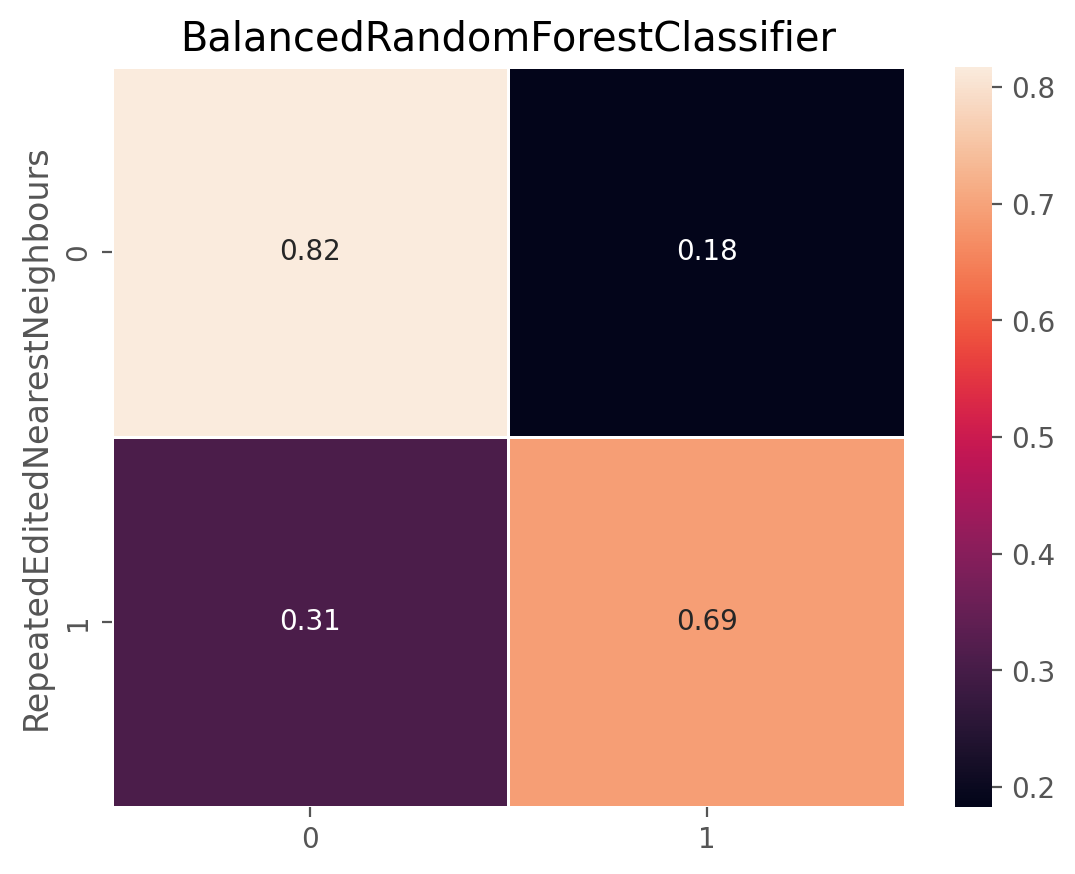

In [51]:
en_best_models=learn(ensemble_dataset, ensemble_models, show_confusion_matrix=True)

In [2]:
m=en_best_models['RepeatedEditedNearestNeighbours']['EasyEnsembleClassifier']['model']
print('model [%s] with acc = [%.4f]' % (m, ms['RepeatedEditedNearestNeighbours']['EasyEnsembleClassifier']['acc']))

NameError: name 'en_best_models' is not defined

# 采用17~21 年的数据进行检验

## 导入数据

In [36]:
def to_lower(s):
    if isinstance(s, list):
        return [ss.lower() for ss in s]
    elif isinstance(s, str):
        return s.lower()

In [37]:
test_accidents=pd.read_csv('./data/uk_accident_17-21/Accidents1721.csv', index_col='accident_index')
test_vehicles=pd.read_csv('./data/uk_accident_17-21/Vehicles1721.csv', index_col='accident_index', error_bad_lines=False, warn_bad_lines=False)
test_vehicles.drop(['accident_reference', 'accident_year'], axis=1, inplace=True)

In [38]:
test_data=test_accidents.join(test_vehicles, how='outer')

In [39]:
test_data.shape

(1146699, 60)

In [40]:
test_data=drop_empty(test_data)
test_data.shape

(57742, 60)

In [41]:
test_feat_to_use=[
    'Accident_Severity',
    # 'Longitude',
    # 'Latitude',
    'Engine_Capacity_cc',
    'Age_of_Vehicle',
    'Day_of_Week',
    'Vehicle_Type',
    'Vehicle_Manoeuvre',
    'Junction_Detail',
    'first_Road_Class',
    'Junction_Location',
]
test_data=test_data[to_lower(test_feat_to_use)]
test_data.shape

(57742, 9)

In [42]:
X_t, y_t = split_X_y(test_data, 'accident_severity')

In [43]:
y_t=y_t.rename('Accident_Severity')

In [44]:
X_t=X_t.rename(mapper={
    'engine_capacity_cc':'Engine_Capacity_(CC)',
    'age_of_vehicle':'Age_of_Vehicle',
    'day_of_week':'Day_of_Week',
    'vehicle_type':'Vehicle_Type',
    'vehicle_manoeuvre':'Vehicle_Manoeuvre',
    'junction_detail':'Junction_Detail',
    'first_road_class':'1st_Road_Class',
    'junction_location':'Junction_Location',
}, axis=1)

In [45]:
X_t=scaler.transform(X_t)

### 修改标签

In [46]:
# y_t[y_t==3] = 0
# y_t[y_t==2] = 1
# y_t[y_t==1] = 1

In [47]:
y_t.value_counts()

0.0    47355
1.0    10387
Name: Accident_Severity, dtype: int64

                       0
Accident_Severity       
1.0                10387
0.0                47355
ratio = [1.0, 4.55906421488399]


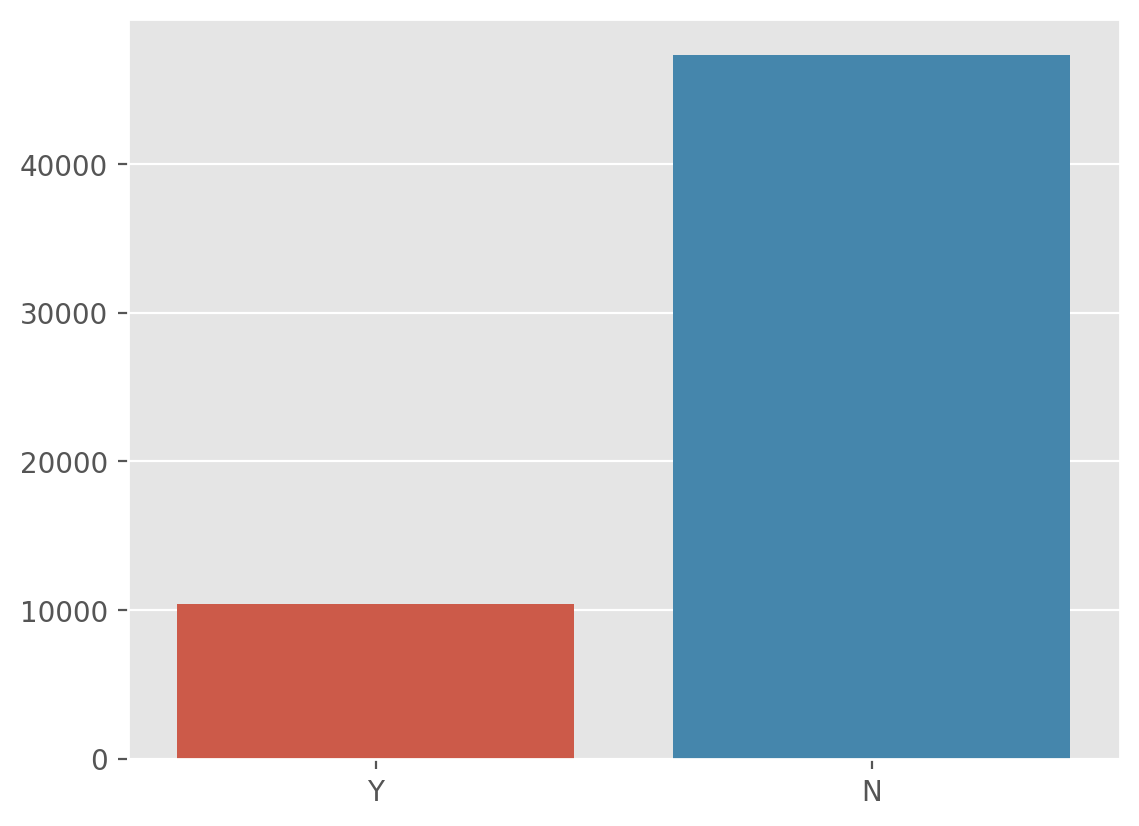

In [48]:
show_severity_distribution(y_t, log=False)

## 开始检验

In [33]:
ms=us_best_models
ms

defaultdict(dict,
            {'RepeatedEditedNearestNeighbours': {'DecisionTreeClassifier': {'model': DecisionTreeClassifier(random_state=233),
               'acc': 0.8445824802068597},
              'ExtraTreesClassifier': {'model': ExtraTreesClassifier(random_state=233),
               'acc': 0.8987558597514629}}})

In [34]:
m1=ms['RepeatedEditedNearestNeighbours']['DecisionTreeClassifier']['model']
m2=ms['RepeatedEditedNearestNeighbours']['ExtraTreesClassifier']['model']

In [49]:
y_1=m1.predict(X_t)
y_2=m2.predict(X_t)

In [79]:
xxx=X_t[10:20]
xxx

array([[-1.09875179, -1.60862815, -1.10092755, -1.52143982,  0.89470823,
         0.22748969,  0.00914063, -0.48120659],
       [-1.09934047, -1.60862815, -1.10092755, -1.52143982,  0.89470823,
         0.22748969,  0.00914063, -0.48120659],
       [ 1.32247148,  1.06614289, -0.06308752, -0.10957323,  0.89470823,
         0.22748969, -0.687753  , -0.48120659],
       [-0.18865912,  0.39745013, -0.06308752, -0.10957323, -1.35204983,
         0.22748969, -0.687753  , -0.48120659],
       [-0.18865912,  1.51193806,  0.45583249, -0.10957323,  0.89470823,
         1.38146833, -0.687753  ,  1.75305978],
       [ 0.2257686 ,  1.95773323,  0.45583249,  1.90737904,  0.89470823,
         1.38146833, -0.687753  ,  1.75305978],
       [ 0.13334651,  0.17455254, -1.10092755, -0.10957323, -0.54963624,
         0.99680878, -0.687753  ,  1.75305978],
       [ 0.03032825, -1.38573056, -1.10092755, -0.10957323, -0.38915352,
         0.99680878, -0.687753  ,  1.75305978],
       [-0.39351827, -0.27124263

In [86]:
yyy=y_t.iloc[10:20]
yyy

accident_index
2020370991103    0.0
2020370991103    0.0
2020370991146    0.0
2020370991146    0.0
2020370991620    0.0
2020370991620    0.0
2020370991655    0.0
2020370991655    0.0
2020370992180    0.0
2020370992578    0.0
Name: Accident_Severity, dtype: float64

In [85]:
m2.predict_proba(xxx)

array([[0.28      , 0.72      ],
       [0.        , 1.        ],
       [0.02      , 0.98      ],
       [1.        , 0.        ],
       [0.116     , 0.884     ],
       [0.54      , 0.46      ],
       [0.91833333, 0.08166667],
       [0.93      , 0.07      ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

Text(0.5, 1.0, 'ExtraTreesClassifier')

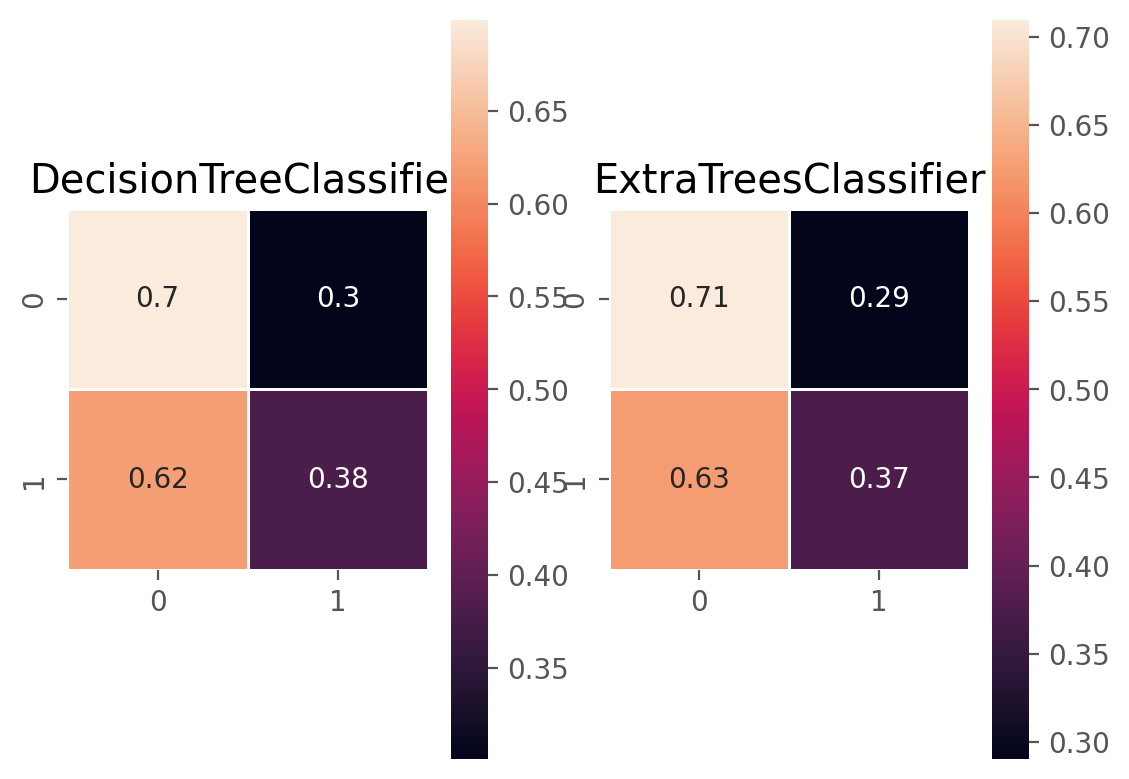

In [52]:
plt.subplot(1,2,1)
sns.heatmap(data=confusion_matrix(y_t, y_1, normalize='true'), square=True, annot=True, fmt='.2g', linewidths=0.5)
plt.title('DecisionTreeClassifier')

plt.subplot(1,2,2)
sns.heatmap(data=confusion_matrix(y_t, y_2, normalize='true'), square=True, annot=True, fmt='.2g', linewidths=0.5)
plt.title('ExtraTreesClassifier')

In [54]:
m=ms['RepeatedEditedNearestNeighbours']['model']
print('model [%s] with acc = [%.4f]' % (m, ms['RepeatedEditedNearestNeighbours']['acc']))

model [BalancedRandomForestClassifier(n_jobs=-1)] with acc = [0.7909]


In [55]:
# 执行预测
y_p=m.predict(X_t)
test_acc=accuracy_score(y_t, y_p)
print(f'{m.__class__.__name__} [ test_acc]={test_acc*100:.2f}')

BalancedRandomForestClassifier [ test_acc]=56.80


<AxesSubplot: >

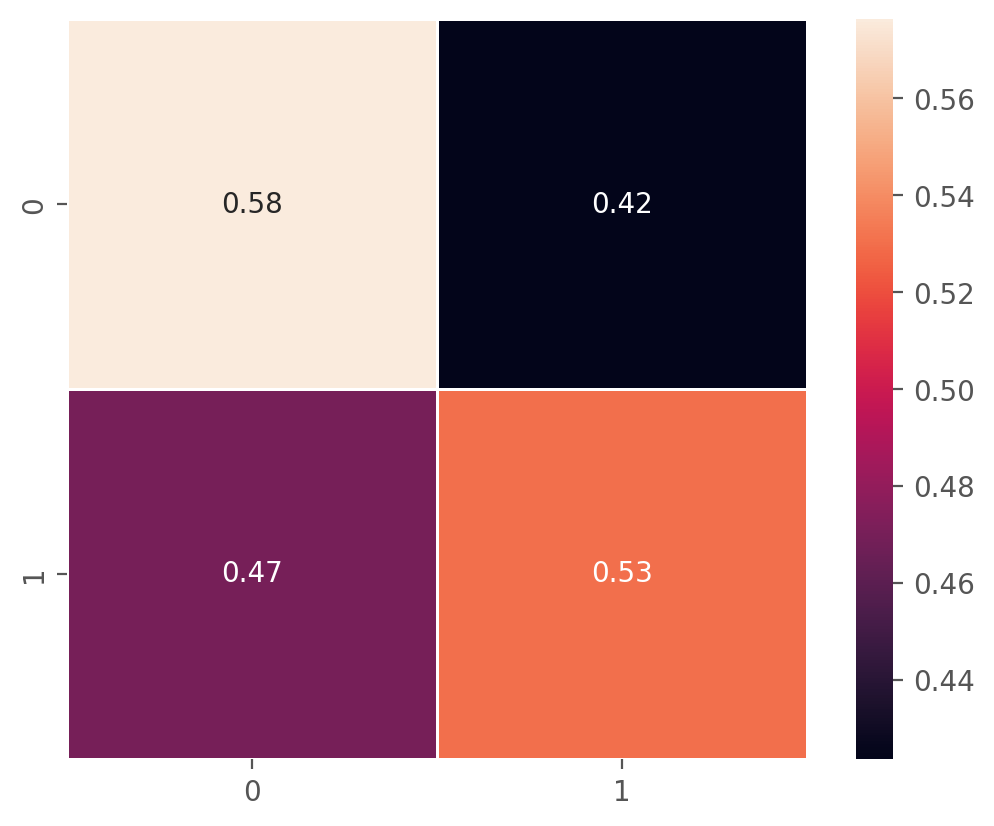

In [56]:
# 混淆矩阵
plt.figure()
sns.heatmap(data=confusion_matrix(y_t, y_p, normalize='true'), square=True, annot=True, fmt='.2g', linewidths=0.5)

In [62]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [63]:
f1_score(y_t, y_p)

0.30639599555061175

In [64]:
recall_score(y_t, y_p)

0.5303745065947819

In [65]:
precision_score(y_t, y_p)

0.21542251593477496

In [ ]:
precision_recall_curve(y_t, m.decision_path(X_t))

# 可视化

## 数据饼图

([<matplotlib.patches.Wedge at 0x7f3ed3153460>,
 [Text(-1.0021398315086356, 0.4535589907650861, 'Y'),
  Text(1.0021398102760055, -0.4535590376786374, 'N')],
 [Text(-0.5466217262774375, 0.24739581314459239, '86.47%'),
  Text(0.546621714696003, -0.2473958387338022, '13.53%')])

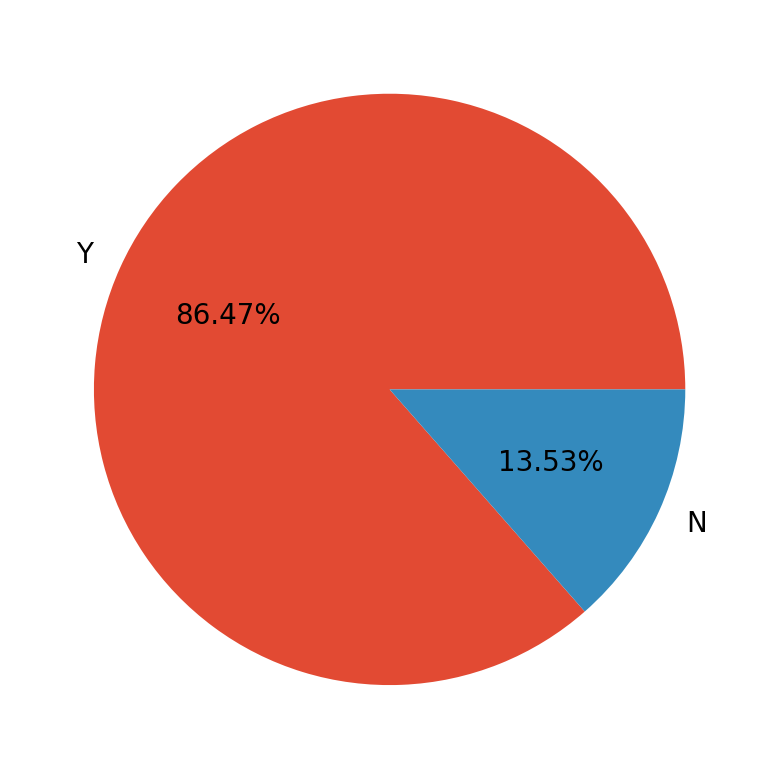

In [86]:
plt.pie(y.value_counts(), labels=['Y', 'N'], autopct='%.2f%%')

In [ ]:
plt.pie(us_renn_y.value_counts(), labels=['Y', 'N'], autopct='%.2f%%')

## 混淆矩阵

In [92]:
from sklearn.metrics import ConfusionMatrixDisplay

<Figure size 640x480 with 0 Axes>

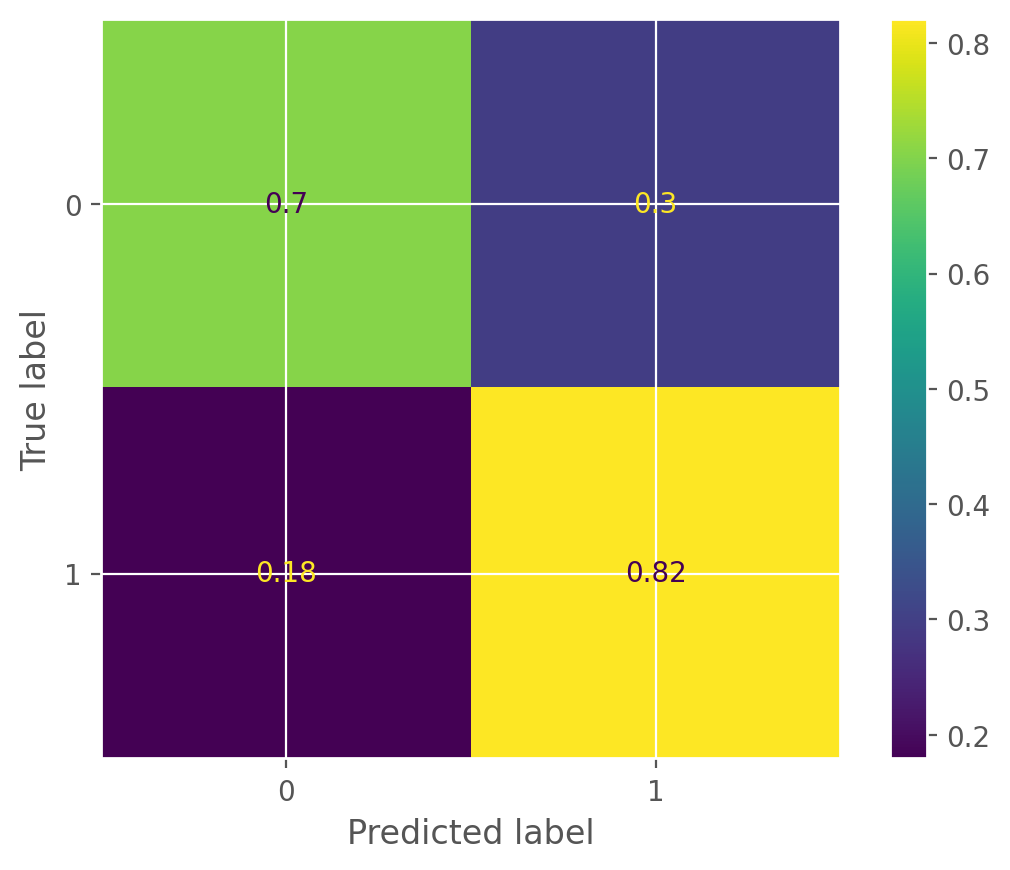

In [95]:
plt.figure()
ConfusionMatrixDisplay.from_predictions(y, us_best_models['RepeatedEditedNearestNeighbours']['model'].predict(X), normalize='true')

     Accident_Severity
3.0              47355
2.0               9884
1.0                503


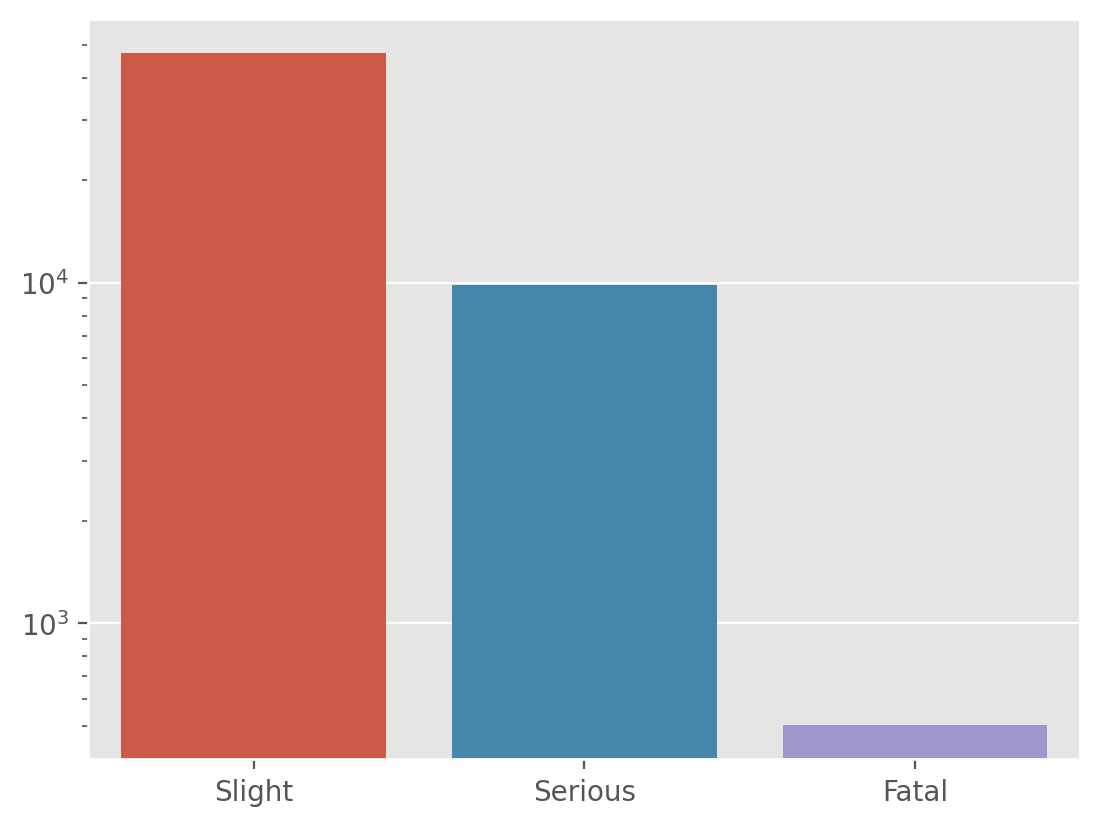

In [136]:
show_severity_distribution(y_t)